In [1]:
# Import libraries
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
# Download historical data for two stocks
stock1 = yf.download("AAPL", start="2020-01-01", end="2023-01-01")
stock2 = yf.download("MSFT", start="2020-01-01", end="2023-01-01")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [3]:
# Display the first few rows of the data
print(stock1.head())
print(stock2.head())

                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2020-01-02  74.059998  75.150002  73.797501  75.087502  72.960480  135480400
2020-01-03  74.287498  75.144997  74.125000  74.357498  72.251137  146322800
2020-01-06  73.447502  74.989998  73.187500  74.949997  72.826843  118387200
2020-01-07  74.959999  75.224998  74.370003  74.597504  72.484352  108872000
2020-01-08  74.290001  76.110001  74.290001  75.797501  73.650345  132079200
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2020-01-02  158.779999  160.729996  158.330002  160.619995  154.215668   
2020-01-03  158.320007  159.949997  158.059998  158.619995  152.295395   
2020-01-06  157.080002  159.100006  156.509995  159.029999  152.689056   
2020-01-07  159.320007  159.669998  157.320007  157.580002  151.296890   
2020-01-08  158.9

In [4]:
# Select 'Close' prices and ensure data covers the same period
stock1_close = stock1['Close']
stock2_close = stock2['Close']

# Align data on the same dates
data = pd.DataFrame({'AAPL': stock1_close, 'MSFT': stock2_close}).dropna()
print(data.head())

                 AAPL        MSFT
Date                             
2020-01-02  75.087502  160.619995
2020-01-03  74.357498  158.619995
2020-01-06  74.949997  159.029999
2020-01-07  74.597504  157.580002
2020-01-08  75.797501  160.089996


Data Cleansing & Preprocessing

In [5]:
# Check for missing values
print(data.isnull().sum())

AAPL    0
MSFT    0
dtype: int64


In [6]:
# Drop rows with missing values
data = data.dropna()
print(data.isnull().sum())

AAPL    0
MSFT    0
dtype: int64


In [7]:
# Resample data to monthly frequency
data_monthly = data.resample('M').mean()
print(data_monthly.head())

                 AAPL        MSFT
Date                             
2020-01-31  77.979048  163.999046
2020-02-29  77.817631  178.719474
2020-03-31  65.611023  152.554091
2020-04-30  68.096547  169.039525
2020-05-31  77.496376  182.342500


In [8]:
# Normalize the data - Normalize data to make the analysis scale-invariant & This helps in comparing different stocks on the same scale.
data_normalized = (data - data.mean()) / data.std()
print(data_normalized.head())

                AAPL      MSFT
Date                          
2020-01-02 -1.806694 -1.791444
2020-01-03 -1.830577 -1.833476
2020-01-06 -1.811193 -1.824859
2020-01-07 -1.822725 -1.855333
2020-01-08 -1.783466 -1.802582


Statistical Analysis

In [9]:
# Calculate the correlation coefficient -  to measure the linear relationship between two stocks.
correlation = data.corr()
print(f"Correlation matrix:\n{correlation}")

Correlation matrix:
          AAPL      MSFT
AAPL  1.000000  0.911635
MSFT  0.911635  1.000000


In [10]:
# Extract the correlation value between AAPL and MSFT
correlation_value = correlation.loc['AAPL', 'MSFT']
print(f"Correlation between AAPL and MSFT: {correlation_value}")

Correlation between AAPL and MSFT: 0.9116353750114395


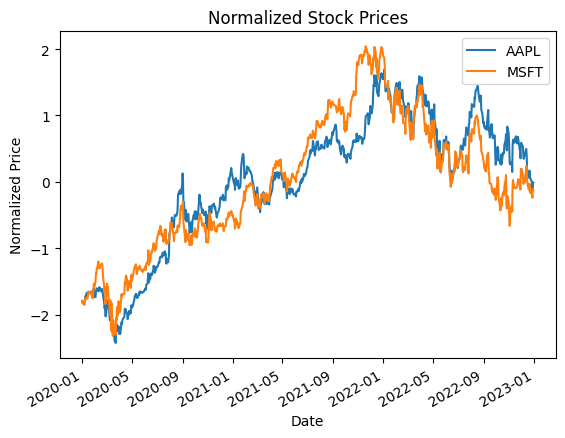

In [11]:
# Plot the normalized prices - to visually inspect the relationship between the two stocks.
data_normalized.plot()
plt.title('Normalized Stock Prices')
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.show()

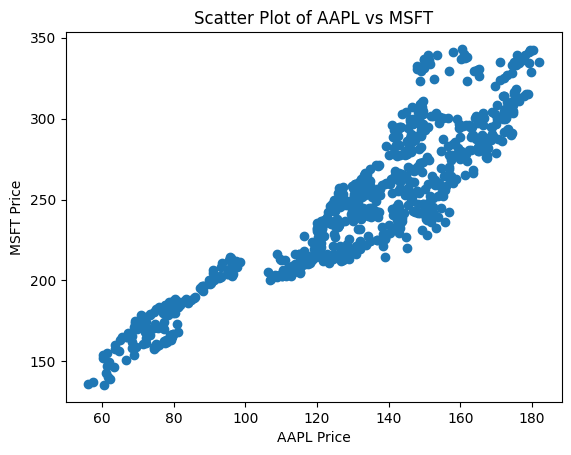

In [14]:
# Scatter plot of AAPL vs MSFT - help visualize the linear relationship.
plt.scatter(data['AAPL'], data['MSFT'])
plt.title('Scatter Plot of AAPL vs MSFT')
plt.xlabel('AAPL Price')
plt.ylabel('MSFT Price')
plt.show()

In [16]:
# Cointegration

from statsmodels.tsa.stattools import coint, adfuller

# Perform cointegration test
score, p_value, _ = coint(data['AAPL'], data['MSFT'])
print(f"Cointegration test p-value: {p_value}")

# Check if the p-value is less than the significance level (e.g., 0.05)
if p_value < 0.05:
    print("The pair is cointegrated")
else:
    print("The pair is not cointegrated")

Cointegration test p-value: 0.5638379653743816
The pair is not cointegrated


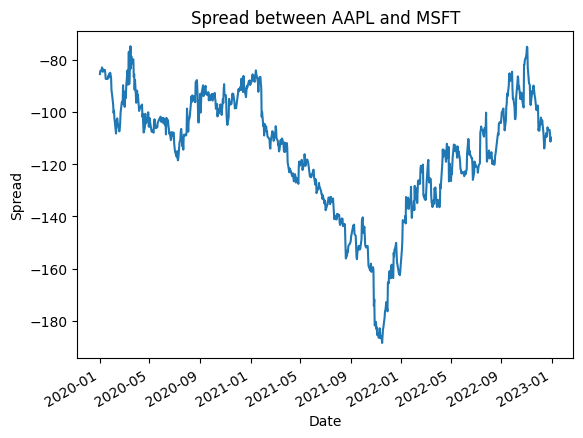

In [18]:
# Spread Calculation and Analysis

# Calculate the spread
spread = data['AAPL'] - data['MSFT']

# Plot the spread
spread.plot()
plt.title('Spread between AAPL and MSFT')
plt.xlabel('Date')
plt.ylabel('Spread')
plt.show()

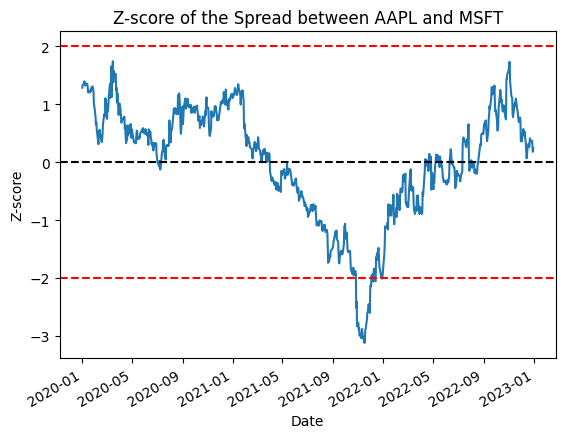

In [19]:
# Z score standardisation of spread

# Z-score normalization
spread_mean = spread.mean()
spread_std = spread.std()
spread_zscore = (spread - spread_mean) / spread_std

# Plot the Z-score of the spread
spread_zscore.plot()
plt.axhline(0, color='black', linestyle='--')
plt.axhline(2, color='red', linestyle='--')
plt.axhline(-2, color='red', linestyle='--')
plt.title('Z-score of the Spread between AAPL and MSFT')
plt.xlabel('Date')
plt.ylabel('Z-score')
plt.show()

Strategy Development

In [20]:
# Entry and Exit Signals


# Define entry and exit thresholds
entry_threshold = 2
exit_threshold = 0

# Generate entry and exit signals
data['zscore'] = spread_zscore
data['long_signal'] = (data['zscore'] < -entry_threshold).astype(int)
data['short_signal'] = (data['zscore'] > entry_threshold).astype(int)
data['exit_signal'] = ((data['zscore'] > exit_threshold) & (data['zscore'] < entry_threshold)).astype(int)

print(data.head())

                 AAPL        MSFT    zscore  long_signal  short_signal  \
Date                                                                     
2020-01-02  75.087502  160.619995  1.283917            0             0   
2020-01-03  74.357498  158.619995  1.338239            0             0   
2020-01-06  74.949997  159.029999  1.346045            0             0   
2020-01-07  74.597504  157.580002  1.392989            0             0   
2020-01-08  75.797501  160.089996  1.336956            0             0   

            exit_signal  
Date                     
2020-01-02            1  
2020-01-03            1  
2020-01-06            1  
2020-01-07            1  
2020-01-08            1  


C:\Users\User\AppData\Local\Temp\ipykernel_13700\1537272588.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['positions'].iloc[i] = 0
C:\Users\User\AppData\Local\Temp\ipykernel_13700\1537272588.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['returns'].iloc[i] = data['positions'].iloc[i-1] * (data['AAPL'].pct_change().iloc[i] - data['MSFT'].pct_change().iloc[i])
C:\Users\User\AppData\Local\Temp\ipykernel_13700\1537272588.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

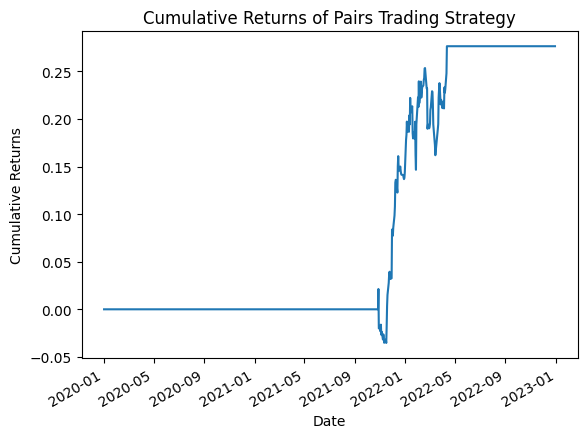

            positions  returns  cumulative_returns
Date                                              
2022-12-23          0     -0.0            0.276413
2022-12-27          0     -0.0            0.276413
2022-12-28          0     -0.0            0.276413
2022-12-29          0      0.0            0.276413
2022-12-30          0      0.0            0.276413


In [22]:
# Backtesting

# Backtesting Framework:
# Track the positions for each trade (long, short, or none).
# Calculate the returns for each position based on the price changes.
# Evaluate the performance using cumulative returns and other metrics.


# Initialize positions and returns
data['positions'] = 0
data['returns'] = 0.0

# Backtesting logic
for i in range(1, len(data)):
    if data['long_signal'].iloc[i] == 1:
        data['positions'].iloc[i] = 1
    elif data['short_signal'].iloc[i] == 1:
        data['positions'].iloc[i] = -1
    elif data['exit_signal'].iloc[i] == 1:
        data['positions'].iloc[i] = 0
    else:
        data['positions'].iloc[i] = data['positions'].iloc[i-1]

    # Calculate returns
    data['returns'].iloc[i] = data['positions'].iloc[i-1] * (data['AAPL'].pct_change().iloc[i] - data['MSFT'].pct_change().iloc[i])

# Calculate cumulative returns
data['cumulative_returns'] = (1 + data['returns']).cumprod() - 1

# Plot cumulative returns
data['cumulative_returns'].plot()
plt.title('Cumulative Returns of Pairs Trading Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.show()

print(data[['positions', 'returns', 'cumulative_returns']].tail())


In [23]:
# Performance metrics

# Calculate performance metrics
total_return = data['cumulative_returns'].iloc[-1]
annualized_return = (1 + total_return) ** (252 / len(data)) - 1
sharpe_ratio = data['returns'].mean() / data['returns'].std() * np.sqrt(252)
max_drawdown = (data['cumulative_returns'].cummax() - data['cumulative_returns']).max()

print(f"Total Return: {total_return:.2%}")
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")

Total Return: 27.64%
Annualized Return: 8.48%
Sharpe Ratio: 1.03
Maximum Drawdown: 9.16%
